In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARMA
from fbprophet import Prophet
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

In [2]:
class box_Prophet():
    def __init__(self, growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.80, uncertainty_samples=1000):
        self.growth = growth
        self.changepoints = changepoints
        self.n_changepoints = n_changepoints
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.holidays = holidays
        self.seasonality_mode = seasonality_mode
        self.seasonality_prior_scale = seasonality_prior_scale
        self.holidays_prior_scale = holidays_prior_scale
        self.changepoint_prior_scale = changepoint_prior_scale
        self.mcmc_samples = mcmc_samples
        self.interval_width = interval_width
        self.uncertainty_samples = uncertainty_samples
    
    def fit(self, x, y):
        self.model = Prophet(growth = self.growth,
                             changepoints = self.changepoints,
                             n_changepoints = self.n_changepoints,
                             yearly_seasonality = self.yearly_seasonality,
                             weekly_seasonality = self.weekly_seasonality,
                             daily_seasonality = self.daily_seasonality,
                             holidays = self.holidays,
                             seasonality_prior_scale = self.seasonality_prior_scale,
                             holidays_prior_scale = self.holidays_prior_scale,
                             changepoint_prior_scale = self.changepoint_prior_scale,
                             mcmc_samples = self.mcmc_samples,
                             interval_width = self.interval_width,
                             uncertainty_samples = self.uncertainty_samples)
        df = pd.DataFrame({'ds':x, 'y':y})
        self.model.fit(df)
    
    def predict(self, n_days=30):
        future = self.model.make_future_dataframe(periods=n_days)
        forecast = self.model.predict(future)
        return forecast['yhat'].tail(n_days).values
    
    def describe(self):
        print('PROPHET - SUMMARY' +
              '\n- growh: ' + str(self.growth) + 
              '\n- changepoints: ' + str(self.changepoints) + 
              '\n- n_changepoints: ' + str(self.n_changepoints) + 
              '\n- yearly_seasonality: ' + str(self.yearly_seasonality) + 
              '\n- weekly_seasonality: ' + str(self.weekly_seasonality) + 
              '\n- daily_seasonality: ' + str(self.daily_seasonality) + 
              '\n- holidays: ' + str(self.holidays) + 
              '\n- seasonality_mode: ' + str(self.seasonality_mode) + 
              '\n- seasonality_prior_scale: ' + str(self.seasonality_prior_scale) + 
              '\n- holidays_prior_scale: ' + str(self.holidays_prior_scale) + 
              '\n- changepoint_prior_scale: ' + str(self.changepoint_prior_scale) + 
              '\n- mcmc_samples: ' + str(self.mcmc_samples) + 
              '\n- interval_width: ' + str(self.interval_width) + 
              '\n- uncertainty_samples: ' + str(self.uncertainty_samples))
        
    def set_params(self, growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.80, uncertainty_samples=1000):
        self.growth = growth
        self.changepoints = changepoints
        self.n_changepoints = n_changepoints
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.holidays = holidays
        self.seasonality_mode = seasonality_mode
        self.seasonality_prior_scale = seasonality_prior_scale
        self.holidays_prior_scale = holidays_prior_scale
        self.changepoint_prior_scale = changepoint_prior_scale
        self.mcmc_samples = mcmc_samples
        self.interval_width = interval_width
        self.uncertainty_samples = uncertainty_samples
        

In [3]:
class box_ExponentialSmoothing():
    def __init__(self, seasonal_periods=365, trend='add', seasonal='add', damped=False):
        self.model = None
        self.seasonal_periods = seasonal_periods
        self.trend = trend
        self.seasonal = seasonal
        self.damped = damped
        
    def fit(self, x, y):
        self.model = ExponentialSmoothing(y,
                                          seasonal_periods = self.seasonal_periods,
                                          trend = self.trend, 
                                          seasonal = self.seasonal,
                                          damped = self.damped).fit()
        
    def predict(self, n_days=30):
        return self.model.forecast(n_days)
    
    def describe(self):
        print('EXPONENTIAL SMOOTHING - SUMMARY'+
              '\n- seasonal_periods: ' + str(self.seasonal_periods) +
              '\n- trend: ' + str(self.trend) + 
              '\n- seasonal: ' + str(self.seasonal) + 
              '\n- damped: ' + str(self.damped))
        
    def set_params(self, seasonal_periods=365, trend='add', seasonal='add', damped=False):
        self.seasonal_periods = seasonal_periods
        self.trend = trend
        self.seasonal = seasonal
        self.damped = damped

In [4]:
class box_SimpleExponentialSmoothing():
    def __init__(self):
        self.model = None
        
    def fit(self, x, y):
        self.model = SimpleExpSmoothing(y).fit()
        
    def predict(self, n_days=30):
        return self.model.predict(start = 1, end = n_days)
    
    def describe(self):
        print('SIMPLE EXPONENTIAL SMOOTHING - SUMMARY \nThere are no parameter to be set on this model.')

In [5]:
class Container():
    def __init__(self):
        self.models={}
        self.start_fit = None
        self.end_fit = None
        self.data = None
    
    def list_models(self, print_message=False):
        all_models = []
        for name, _ in self.models.items():
            all_models.append(name)
        if print_message and (len(all_models)>0):
            print('Models on this container: \n')
            print(all_models)
            return all_models
        elif print_message and (len(all_models)==0):
            print('There are no models on this container yet.\nYou can add one using the .add_model() function.')
            return None
        else:
            return all_models
        
    def add_model(self, name, model):
        if name in self.models:
            raise ValueError("There's already a model called " + name + ", please, choose another name.")
        else:
            self.models[name]=model
        
    def remove_model(self, name):
        if name not in self.models:
            raise ValueError("There is not model called " + name + "on this container.\nIf you want a list of models, use the .list_models() function. ")
        self.models.pop(name, None)
            
    def n_models(self):
        return len(self.models)
    
    def fit(self, x, y, print_message=False, name=None):
        self.start_fit = pd.to_datetime(x.min())
        self.end_fit = pd.to_datetime(x.max())
        self.data = pd.DataFrame({'x':x, 'y':y})
        
        if name is None:
            for name, model in self.models.items():
                model.fit(x, y)
                if print_message:
                    print('Model ' + name + ' - Fit - Done')
        else:
            self.models[name].fit(x,y)
            if print_message:
                    print('Model ' + name + ' - Fit - Done')
    
    def predict(self, n_days=30, print_message=False, name=None):
        dates = [self.end_fit + datetime.timedelta(days=i+1) for i in range(n_days)]
        pred = {'date':dates}
        
        if name is None:
            for name, model in self.models.items():
                pred[name] = model.predict(n_days)
                if print_message:
                    print('Model ' + name + ' - Predict - Done')
            pred_df = pd.DataFrame(pred).set_index('date')
            return pred_df
        else:
            pred[name] = self.models[name].predict(n_days)
            if print_message:
                print('Model ' + name + ' - Predict - Done')
            pred_df = pd.DataFrame(pred).set_index('date')
            return pred_df              
            
    
    def split_data(self, x, y, training_init=None, training_end=None, scoring_init=None, scoring_end=None):
        data = pd.DataFrame({'date':x, 'value':y})
        training_data = data[(data.date>=training_init)&(data.date<=training_end)]
        scoring_data = data[(data.date>=scoring_init)&(data.date<=scoring_end)] 
        return training_data.date.values, training_data.value.values, scoring_data.date.values, scoring_data.value.values
    
    def choose_model(self, x, y, error_metric=None, best_min=True, training_init=None, training_end=None, scoring_init=None, scoring_end=None):
        x_train, y_train, x_score, y_score = self.split_data(x,
                                                             y,
                                                             training_init=training_init,
                                                             training_end=training_end,
                                                             scoring_init=scoring_init,
                                                             scoring_end=scoring_end)
        
        self.fit(x_train, y_train)
        y_pred = self.predict(len(x_score))
        y_pred['y_true'] = y_score
        errors = {}
        for name, model in self.models.items():
            errors[name] = error_metric(y_true = y_pred.y_true,
                                        y_pred = y_pred[name])
        
        if best_min==True:
            best_model = min(errors, key=errors.get)
            
        elif best_min==False:
            best_model = max(errors, key=errors.get)
        
        return y_pred, best_model, errors
    
    def describe(self):
        if self.n_models()>=0:
            print('CONTAINER - SUMMARY: \n')
            for name, model in self.models.items():
                model.describe()
                print()
        else:
            print('There are no boxes on this container.')
        

In [6]:
data = pd.read_csv('hawaii_data.csv')

data = data.groupby('FL_DATE').YEAR.count().reset_index()
data.columns = ['ds', 'y']
data.ds = pd.to_datetime(data.ds)

In [7]:
cont = Container()
cont.add_model('prophet', box_Prophet())
cont.add_model('exp', box_ExponentialSmoothing(seasonal_periods=7))
cont.add_model('exp_damped', box_ExponentialSmoothing(damped=True, seasonal_periods=7))
cont.add_model('exp_mul', box_ExponentialSmoothing(seasonal='mul', seasonal_periods=7))
cont.add_model('simple_exp', box_SimpleExponentialSmoothing())

In [853]:
res, best_model, errors = cont.choose_model(data['ds'], 
                                            data['y'],
                                            error_metric = mean_absolute_error,
                                            best_min=True,
                                            training_init='2017-01-01',
                                            training_end='2017-12-31',
                                            scoring_init='2018-01-01',
                                            scoring_end='2018-06-01')

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:1010: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()
/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:1134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  seasonal = np.matmul(seasonal_features.as_matrix(), beta) * self.y_scale


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2015-01-01 00:00:00
2018-03-31 00:00:00


/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:1010: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = seasonal_features.as_matrix()
/Users/guilhermeperticarari/anaconda3/lib/python3.6/site-packages/fbprophet/forecaster.py:1134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  seasonal = np.matmul(seasonal_features.as_matrix(), beta) * self.y_scale


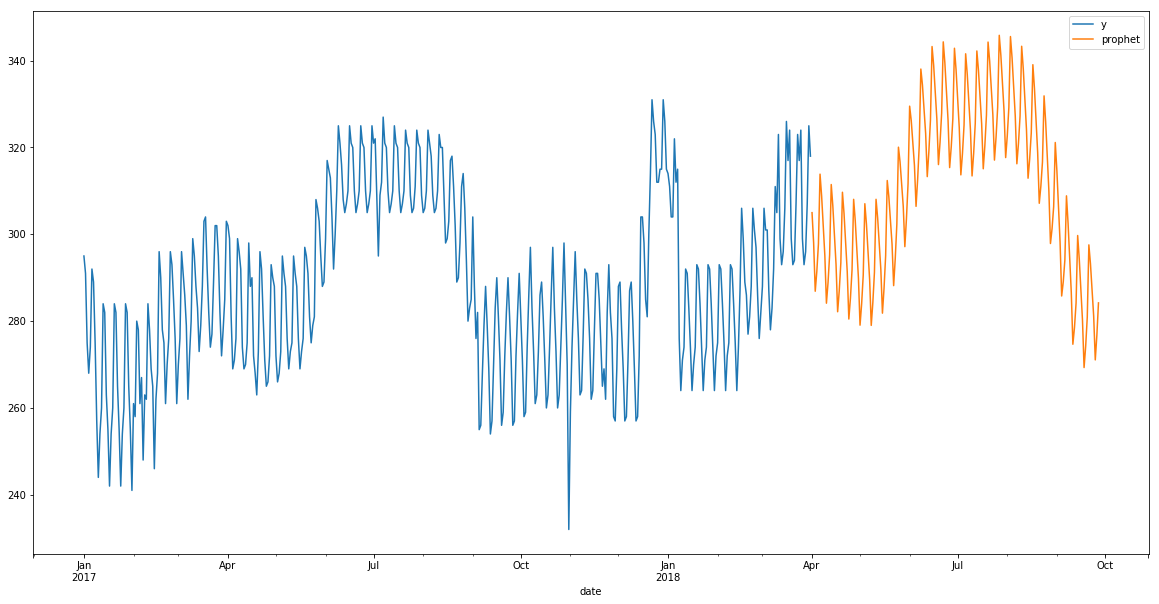

In [876]:
aux = data[(data.ds>='2015-01-01')&(data.ds<='2018-12-31')]
cont.fit(aux.ds, aux.y, name='prophet')
print(cont.start_fit)
print(cont.end_fit)
best_pred = cont.predict(n_days=6*30, name='prophet')

fig, ax = plt.subplots(figsize=(20,10))
data[data.ds>='2017-01-01'].plot(x='ds', y='y', ax=ax)
best_pred.plot(ax=ax)

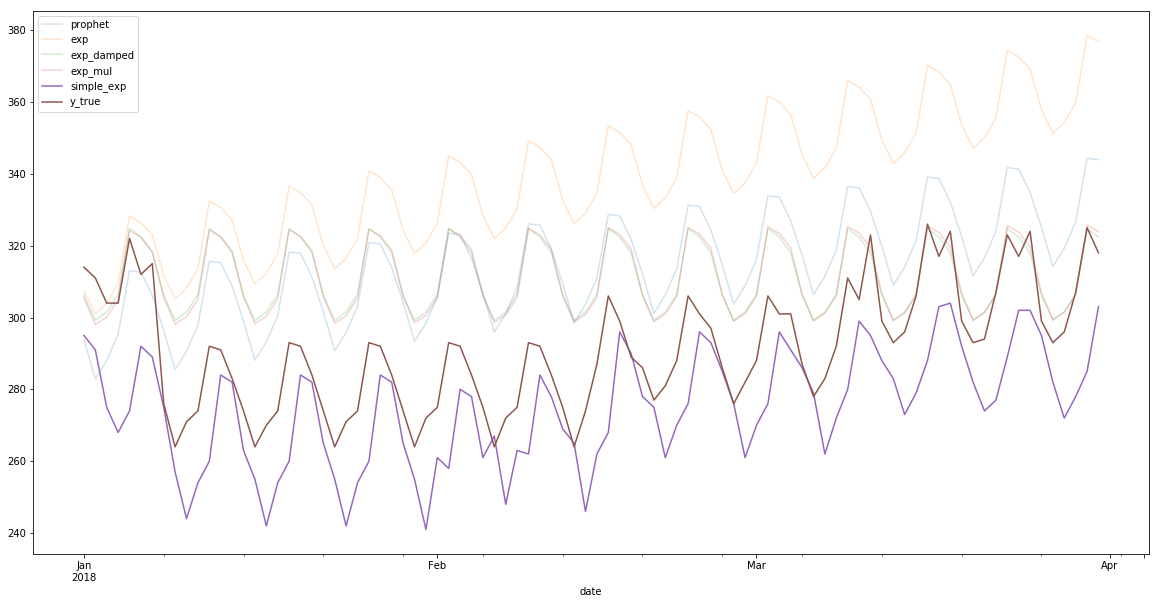

In [877]:
fig, ax = plt.subplots(figsize=(20,10))
res.plot(y='prophet', ax=ax, alpha=0.2)
res.plot(y='exp', ax=ax, alpha=0.2)
res.plot(y='exp_damped', ax=ax, alpha=0.2)
res.plot(y='exp_mul', ax=ax, alpha=0.2)
res.plot(y='simple_exp', ax=ax)
res.plot(y='y_true', ax=ax)

In [8]:
cont.describe()

CONTAINER - SUMMARY: 

PROPHET - SUMMARY
- growh: linear
- changepoints: None
- n_changepoints: 25
- yearly_seasonality: auto
- weekly_seasonality: auto
- daily_seasonality: auto
- holidays: None
- seasonality_mode: additive
- seasonality_prior_scale: 10.0
- holidays_prior_scale: 10.0
- changepoint_prior_scale: 0.05
- mcmc_samples: 0
- interval_width: 0.8
- uncertainty_samples: 1000

EXPONENTIAL SMOOTHING - SUMMARY
- seasonal_periods: 7
- trend: add
- seasonal: add
- damped: False

EXPONENTIAL SMOOTHING - SUMMARY
- seasonal_periods: 7
- trend: add
- seasonal: add
- damped: True

EXPONENTIAL SMOOTHING - SUMMARY
- seasonal_periods: 7
- trend: add
- seasonal: mul
- damped: False

SIMPLE EXPONENTIAL SMOOTHING - SUMMARY 
There are no parameter to be set on this model.



In [855]:
errors

{'prophet': 24.567681110581347,
 'exp': 47.682960437623699,
 'exp_damped': 20.394297640943186,
 'exp_mul': 20.342901033069602,
 'simple_exp': 16.833333333333332}